In [1]:
import pandas
import numpy 
import seaborn
import matplotlib.pyplot as plt
import plotly.express as px

import plotly.io as pio
pio.renderers.default = "png"

In [2]:
df = pandas.read_csv("./data/train.csv")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [3]:
df["Order Date"] = pandas.to_datetime(df["Order Date"], infer_datetime_format=True)
df["Ship Date"] = pandas.to_datetime(df["Ship Date"], infer_datetime_format=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   datetime64[ns]
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

In [5]:
# Identifying missing/null values

missing_values = df.isnull()
for cols in missing_values.columns:
    print(cols,': ', end="")
    print(missing_values[cols].value_counts())

Row ID : False    9800
Name: Row ID, dtype: int64
Order ID : False    9800
Name: Order ID, dtype: int64
Order Date : False    9800
Name: Order Date, dtype: int64
Ship Date : False    9800
Name: Ship Date, dtype: int64
Ship Mode : False    9800
Name: Ship Mode, dtype: int64
Customer ID : False    9800
Name: Customer ID, dtype: int64
Customer Name : False    9800
Name: Customer Name, dtype: int64
Segment : False    9800
Name: Segment, dtype: int64
Country : False    9800
Name: Country, dtype: int64
City : False    9800
Name: City, dtype: int64
State : False    9800
Name: State, dtype: int64
Postal Code : False    9789
True       11
Name: Postal Code, dtype: int64
Region : False    9800
Name: Region, dtype: int64
Product ID : False    9800
Name: Product ID, dtype: int64
Category : False    9800
Name: Category, dtype: int64
Sub-Category : False    9800
Name: Sub-Category, dtype: int64
Product Name : False    9800
Name: Product Name, dtype: int64
Sales : False    9800
Name: Sales, dtype: in

In [6]:
df.describe(include="all", datetime_is_numeric=True)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
count,9800.000000,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9789.000000,9800,9800,9800,9800,9800,9800.000000
unique,NaN,4922,NaN,NaN,4,793,793,3,1,529,49,NaN,4,1861,3,17,1849,NaN
top,NaN,CA-2018-100111,NaN,NaN,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,NaN,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope,NaN
freq,NaN,14,NaN,NaN,5859,35,35,5101,9800,891,1946,NaN,3140,19,5909,1492,47,NaN
mean,4900.500000,NaN,2017-04-12 14:24:35.265306368,2017-04-21 19:45:12.489796096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55273.322403,NaN,NaN,NaN,NaN,NaN,230.769059
min,1.000000,NaN,2015-01-02 00:00:00,2015-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1040.000000,NaN,NaN,NaN,NaN,NaN,0.444000
25%,2450.750000,NaN,2016-05-02 12:00:00,2016-05-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23223.000000,NaN,NaN,NaN,NaN,NaN,17.248000
50%,4900.500000,NaN,2017-05-30 00:00:00,2017-06-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58103.000000,NaN,NaN,NaN,NaN,NaN,54.490000
75%,7350.250000,NaN,2018-04-11 00:00:00,2018-05-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90008.000000,NaN,NaN,NaN,NaN,NaN,210.605000
max,9800.000000,NaN,2018-12-30 00:00:00,2019-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99301.000000,NaN,NaN,NaN,NaN,NaN,22638.480000


In [7]:
size_by_state = df["State"].value_counts().to_frame()
size_by_state.reset_index(inplace=True)
size_by_state.columns = ["States", "Counts"]
size_by_state.sort_values(by="Counts", ascending=False, inplace=True)

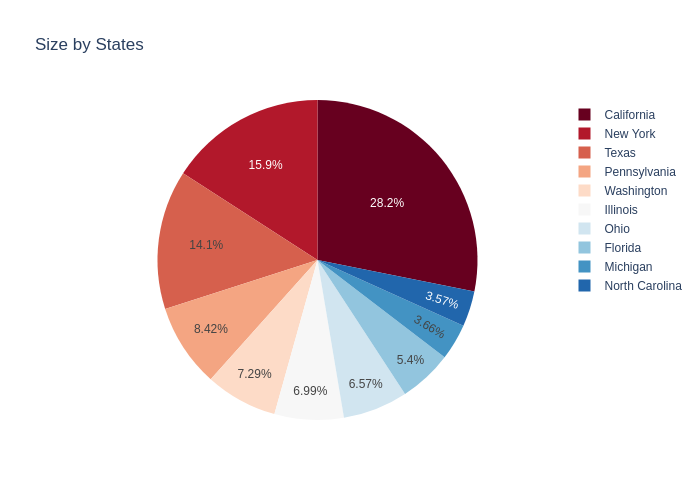

In [8]:

fig = px.pie(size_by_state[:10], 
             values='Counts', 
             names='States', 
             title='Size by States',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

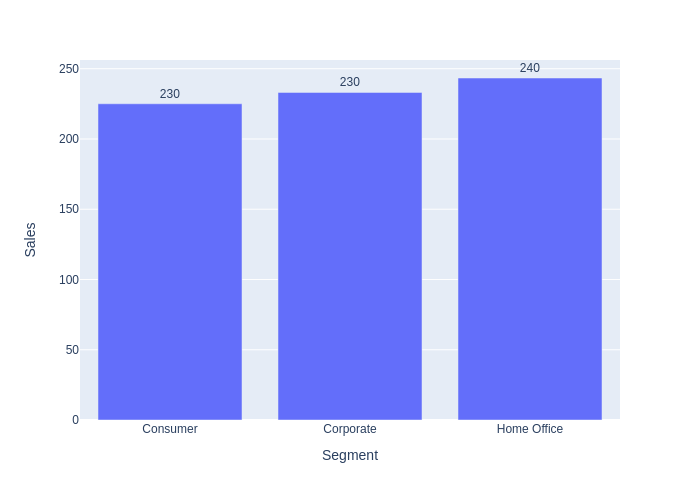

In [9]:
sales_by_segment = df.groupby("Segment")["Sales"].mean().to_frame()
sales_by_segment.reset_index(inplace=True)

fig = px.bar(sales_by_segment,
            x="Segment",
            y="Sales",
            text="Sales")
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

In [10]:
segement_by_category = df.groupby(["Segment", "Sub-Category"])["Sales"].sum().to_frame()
segement_by_category.reset_index(inplace=True)

In [11]:
segement_by_category.head()

,Segment,Sub-Category,Sales
0,Consumer,Accessories,85699.074
1,Consumer,Appliances,52367.233
2,Consumer,Art,14062.256
3,Consumer,Binders,117091.909
4,Consumer,Bookcases,67949.397


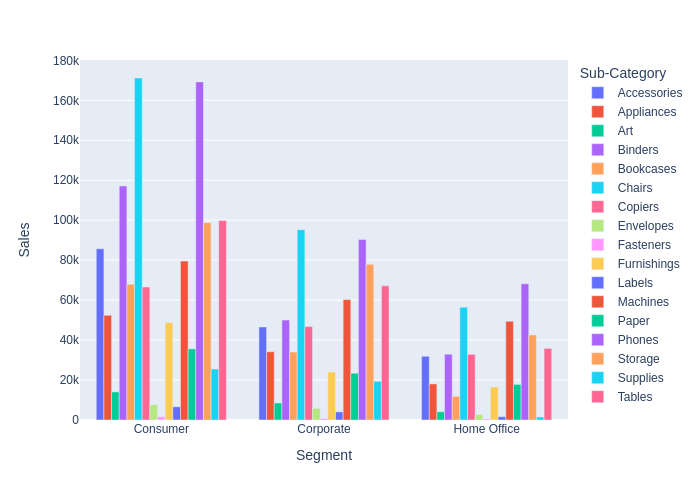

In [12]:
fig = px.bar(segement_by_category,
            x="Segment",
            y="Sales",
            barmode="group",
            color="Sub-Category")
fig.show()

In [13]:
ordertime_by_sales = df[["Order Date", "Sales"]]
ordertime_by_sales.set_index(keys="Order Date", inplace=True)

In [14]:
order_per_day = ordertime_by_sales.resample("D").sum()

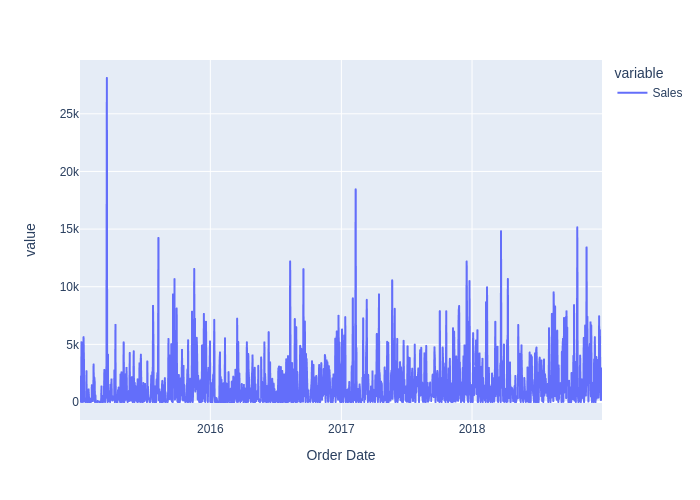

In [15]:
fig = px.line(order_per_day)
fig.show()

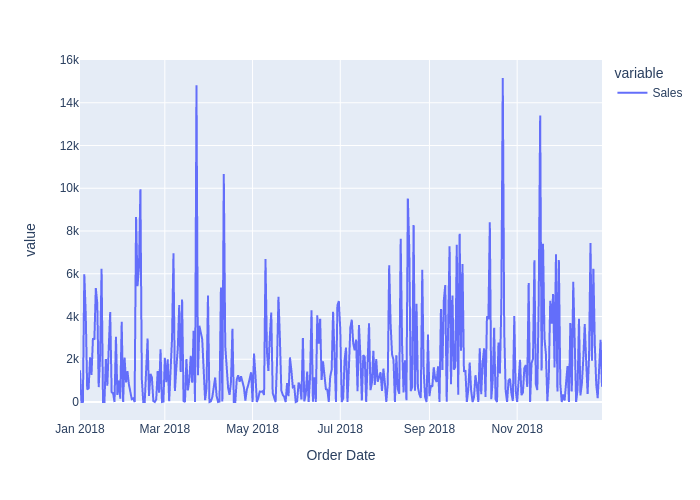

In [16]:
fig = px.line(order_per_day.loc["2018"])
fig.show()

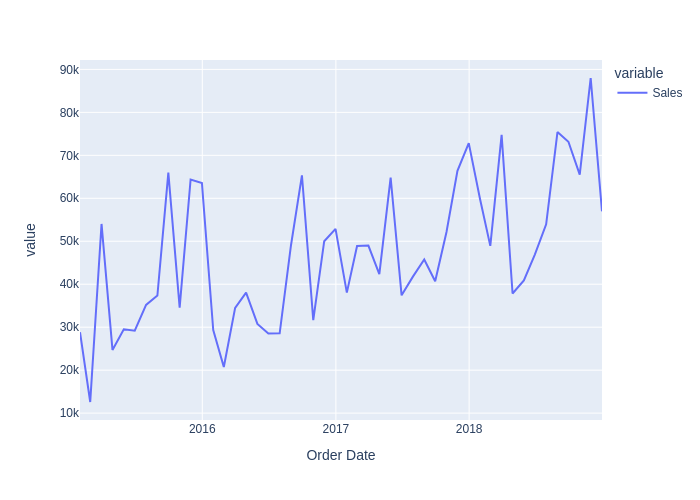

In [17]:
order_per_Month = ordertime_by_sales.resample("M").sum()
fig = px.line(order_per_Month)
fig.show()

In [18]:
df["order_year"] = df["Order Date"].dt.year
df["order_month"] = df["Order Date"].dt.month
df["order_wek"] = df["Order Date"].dt.isocalendar().week

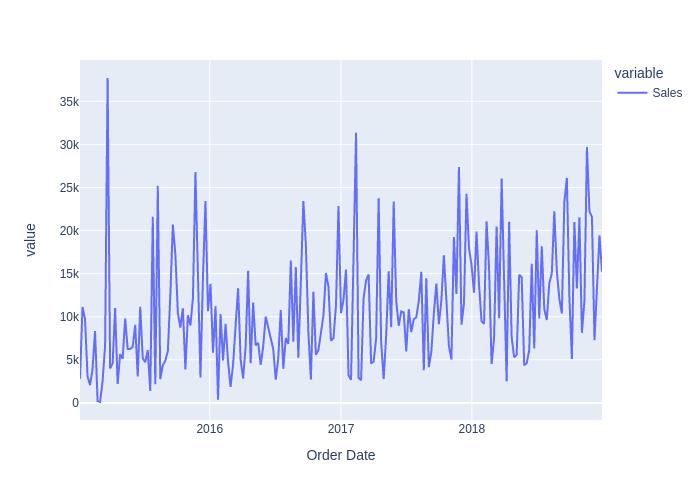

In [19]:
order_per_week = ordertime_by_sales.resample("W").sum()
fig = px.line(order_per_week)
fig.show()

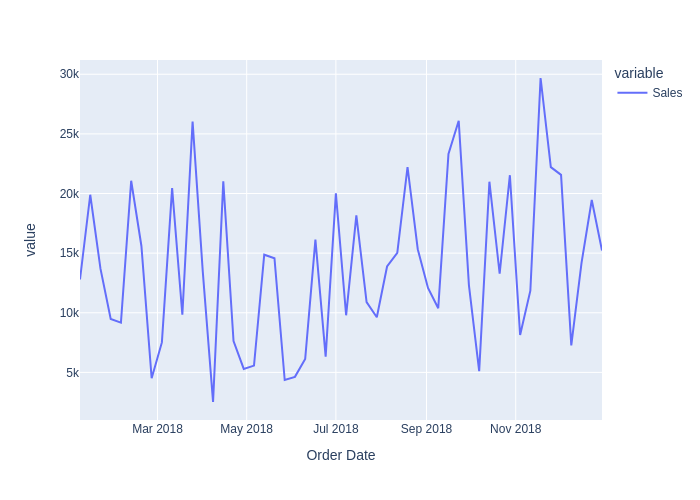

In [20]:
order_by_year = ordertime_by_sales.resample("W").sum()
fig = px.line(order_by_year.loc["2018"])
fig.show()

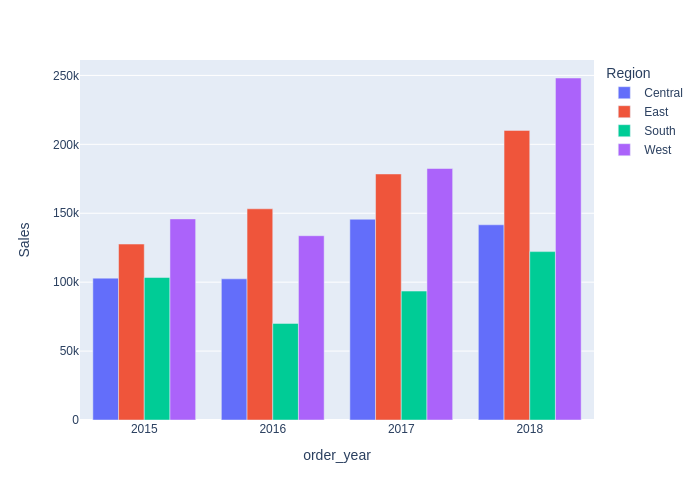

In [21]:
sales_by_region = df.groupby(["order_year", "Region"])["Sales"].sum().to_frame()
sales_by_region.reset_index(inplace=True)
fig = px.bar(sales_by_region,
            x="order_year",
            y="Sales",
            barmode="group",
            color="Region")
fig.show()

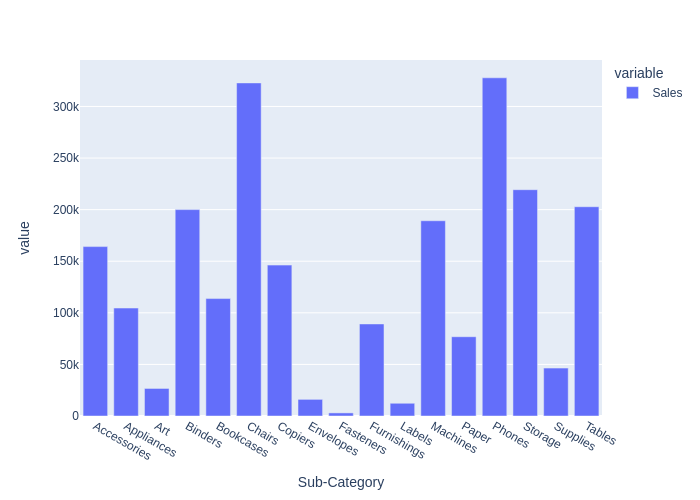

In [22]:
sales_by_subcat = df.groupby("Sub-Category")["Sales"].sum()
fig = px.bar(sales_by_subcat)
fig.show()

In [23]:
counts_by_subcat = df["Sub-Category"].value_counts().to_frame()
counts_by_subcat.reset_index(inplace=True)
counts_by_subcat.columns = ["Sub-Category", "Frequency"]

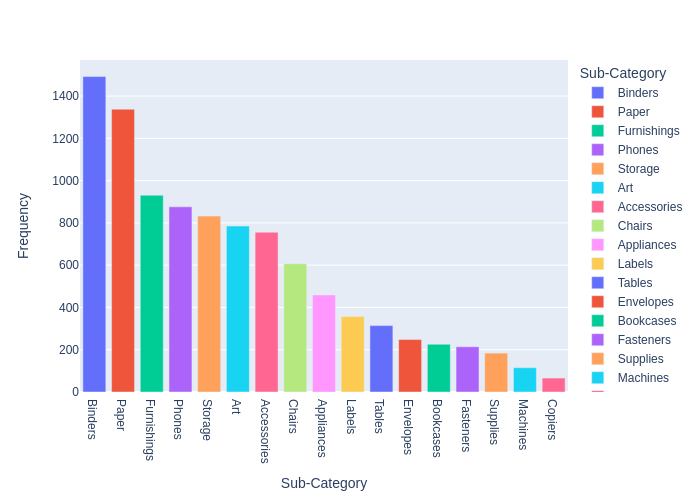

In [24]:
fig = px.bar(counts_by_subcat, 
             x='Sub-Category', 
             y='Frequency',
             color='Sub-Category')
fig.show()